# Todo
 - Masked transformers
 - any more data reductions?
 

In [ ]:
from CoReDataLoader import  dataset, dataloader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchmetrics as metrics
import wandb

In [ ]:
class classifier(nn.Module):
    def __init__(self,input_length = dataset.output_length):
        super().__init__()
        self.inlayer = nn.Linear(input_length,4096*3)
        self.bnorm1 = nn.BatchNorm1d(4096*3)
        self.inter1 = nn.Linear(4096*3,4096*2)
        self.bnorm2 = nn.BatchNorm1d(4096*2)
        self.inter2 = nn.Linear(4096*2,4096)
        self.bnorm3 = nn.BatchNorm1d(4096)
        self.inter3 = nn.Linear(4096,2)
        self.softmax = nn.Softmax()
        self.activation = nn.GELU()

    def forward(self,inp):
        itn = inp.to(torch.float32)
        itn = F.normalize(itn, 0)
        itn = self.inlayer(itn)
        itn = self.bnorm1(itn)
        itn = self.inter1(itn)
        itn = self.activation(itn)
        itn = self.bnorm2(itn)
        itn = self.inter2(itn)
        itn = self.activation(itn)
        itn = self.bnorm3(itn)
        itn = self.inter3(itn)
        itn = self.activation(itn)

        return itn
        
net = classifier().to(dataset.device)

In [ ]:
acc = metrics.WeightedMeanAbsolutePercentageError().to(dataset.device)
acc2 = metrics.MeanSquaredError().to(dataset.device)    

In [ ]:
acc(torch.tensor([1,1,1]),torch.tensor([1,1,1]))

In [ ]:
def get_error():
    with torch.no_grad():
        tss,params = next(iter(DataLoader(dataset, batch_size=len(dataset))))
        return acc(net(tss),params[:,1:])


In [ ]:
def get_mse_error():
    with torch.no_grad():
        tss,params = next(iter(DataLoader(dataset, batch_size=len(dataset))))
        return acc2(net(tss),params[:,1:])


# Run from below here to test new runs

In [ ]:
"""
 ▄▄▄▄▄▄   ▄▄   ▄▄ ▄▄    ▄    ▄▄▄▄▄▄▄ ▄▄▄▄▄▄   ▄▄▄▄▄▄▄ ▄▄   ▄▄
█   ▄  █ █  █ █  █  █  █ █  █       █   ▄  █ █       █  █▄█  █
█  █ █ █ █  █ █  █   █▄█ █  █    ▄▄▄█  █ █ █ █   ▄   █       █
█   █▄▄█▄█  █▄█  █       █  █   █▄▄▄█   █▄▄█▄█  █ █  █       █
█    ▄▄  █       █  ▄    █  █    ▄▄▄█    ▄▄  █  █▄█  █       █
█   █  █ █       █ █ █   █  █   █   █   █  █ █       █ ██▄██ █
█▄▄▄█  █▄█▄▄▄▄▄▄▄█▄█  █▄▄█  █▄▄▄█   █▄▄▄█  █▄█▄▄▄▄▄▄▄█▄█   █▄█

"""
print("Original error: ", get_error())

In [ ]:
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()
lr = 3e-5
amsgrad = False
# sgd = optim.SGD(net.parameters(), lr=lr,momentum = 0.8,nesterov = True)
adam = optim.Adam(net.parameters(),lr = lr,amsgrad=amsgrad)
optimizer = adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience = 50)
epochs = 1200


In [ ]:
from datetime import datetime
ctime = datetime.now()
stime = f"{ctime.date().isoformat()}-{ctime.time().hour}-{ctime.time().minute}"
stime

In [ ]:
from collections import OrderedDict
best = OrderedDict()

In [44]:
wandb.init(project="M1M2regressor")
wandb.watch(net)
wandb.log({"lr":lr,"amsgrad":amsgrad})
# wandb.
losses = []

errors = [10000000000000]
error = get_error()
sacc = []
error = 0
bestepoch = 0
for epoch in range(epochs):
    for batch, (ts,params) in enumerate(dataloader):
        
        params = params[:,1:].to(dataset.device)    
        optimizer.zero_grad()
        outputs = net(ts.to(dataset.device))
        
        loss = criterion(outputs,params)
        loss += criterion2(outputs,params)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        scheduler.step(error)
        wandb.log({"loss":loss.item(),"batch_err":acc(outputs,params)})

    error = get_error()
    mse_error = get_mse_error()
    errors.append(error)
    # print(epoch, error ,end = " | ")

    if error <= min(errors) or (error <= min(errors) and loss.item() <= min(losses)): # ignore
        net.state_dict(destination = best)
        best = net.state_dict()
        torch.save(best, f"./saved_models/INTRAIN_{stime}_Acc_{lr}_{amsgrad}.pt")
        bestepoch = epoch
        print(f"MODEL SAVED AT error: {error}, MSE error {mse_error}, and EPOCH {epoch}")

    
    wandb.log({"epoch":epoch,"current_error":error,"mse_error":mse_error,"min_error":min(errors)})

torch.save(best, f"./saved_models/{stime}_Best_Model_Epoch_{bestepoch}_err_{max(errors)}_{lr}_{amsgrad}.pt")

KeyboardInterrupt: 

In [45]:
torch.save(best, f"./saved_models/{stime}_Best_Model_Epoch_{bestepoch}_Acc_{min(errors)}_{lr}_{amsgrad}.pt")

In [ ]:
get_error()

In [ ]:
net.load_state_dict(best)
get_error()

In [ ]:
print(best)

In [68]:
lends = len(dataset)
# lends = 5
tss,params = next(iter(DataLoader(dataset, batch_size=lends,shuffle=True)))
outs = net(tss)

# for i,v in zip():
errors = [[] for i in dataset.eoss]
print(dataset.eoss)
for a,b,c in zip(outs.reshape(-1),params[:,1:].reshape(-1),params[:,0:].reshape(-1)):
    print(f"{a.item()},{b.item()} | {a.item()-b.item()} | {c.item()}")
    errors[int(c.item())].append(a.item()-b.item())
errors

['2B', '2H', 'ALF2', 'BHBlp', 'BLQ', 'BLh', 'DD2', 'ENG', 'G2', 'G2k123', 'H4', 'LS220', 'MPA1', 'MS1', 'MS1b', 'SFHo', 'SLy', 'SLy4', 'sly']
1.3439686298370361,1.350607991218567 | -0.006639361381530762 | 16.0
1.363497018814087,1.350607991218567 | 0.01288902759552002 | 1.350607991218567
1.3342913389205933,1.350000023841858 | -0.01570868492126465 | 1.350607991218567
1.3153550624847412,1.350000023841858 | -0.0346449613571167 | 16.0
1.3840336799621582,1.350492000579834 | 0.03354167938232422 | 1.350000023841858
1.318708896636963,1.350492000579834 | -0.031783103942871094 | 1.350000023841858
1.6659495830535889,1.7000279426574707 | -0.034078359603881836 | 16.0
1.7216876745224,1.7000279426574707 | 0.0216597318649292 | 1.350492000579834
1.3428889513015747,1.350492000579834 | -0.007603049278259277 | 1.350492000579834
1.3126925230026245,1.350492000579834 | -0.03779947757720947 | 14.0
1.3624931573867798,1.3812700510025024 | -0.018776893615722656 | 1.7000279426574707
1.3988007307052612,1.3812700510

[[-0.018586039543151855,
  0.001635432243347168,
  0.06713414192199707,
  -0.05717504024505615,
  0.023688554763793945,
  0.020995259284973145,
  0.04417574405670166,
  0.06954622268676758,
  0.006249785423278809,
  0.04286646842956543,
  -0.0793302059173584,
  -0.00875234603881836,
  -0.005703091621398926,
  -0.00903940200805664,
  -0.009108543395996094,
  0.03134047985076904,
  4.3272972106933594e-05,
  -0.0004024505615234375,
  -0.032143354415893555,
  -0.04096662998199463,
  -0.02178347110748291,
  0.007575392723083496,
  -0.005176186561584473,
  -0.029021143913269043,
  -0.04930603504180908,
  0.022266745567321777,
  0.043298959732055664,
  -0.0024684667587280273,
  -0.026232600212097168,
  -0.03343629837036133,
  0.055499911308288574,
  0.012560606002807617,
  0.007265210151672363,
  -0.01704418659210205,
  0.01613008975982666,
  0.003644227981567383,
  -0.01868414878845215,
  -0.02843761444091797,
  -0.015711307525634766,
  0.02679443359375,
  -0.02686178684234619,
  -0.07700777

In [66]:
errors

[[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]]

In [70]:
from scipy.stats import describe
for i,v in enumerate(errors):
    print(i,describe(v))

0 DescribeResult(nobs=77, minmax=(-0.10285437107086182, 0.08022785186767578), mean=-0.0029086114524246812, variance=0.001193496451256935, skewness=-0.04820398736668162, kurtosis=0.40592212276904904)
1 DescribeResult(nobs=2951, minmax=(-1.1085645724087954, 1.693355917930603), mean=0.0004535802219963122, variance=0.00320960105399057, skewness=4.597652969548597, kurtosis=338.88486074758936)
2 DescribeResult(nobs=142, minmax=(-0.10081017017364502, 0.5048781633377075), mean=0.004661247344084189, variance=0.0032007436705510537, skewness=4.947642977754282, kurtosis=41.21303528843889)
3 DescribeResult(nobs=10, minmax=(-0.04656994342803955, 0.08051741123199463), mean=0.0030575871467590334, variance=0.0015732910749712739, skewness=0.5884416485180644, kurtosis=-0.5303013130049359)
4 DescribeResult(nobs=9, minmax=(-0.01675283908843994, 0.058923959732055664), mean=0.015527195400661893, variance=0.0005984598593724084, skewness=0.29897212064027184, kurtosis=-0.798220142513443)
5 DescribeResult(nobs=2

In [49]:
import matplotlib.pyplot as plt

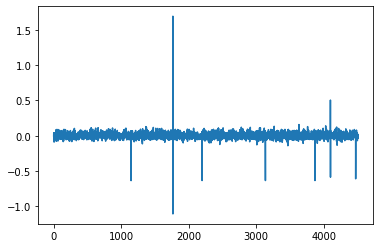

In [50]:
plt.plot(errors)

(array([1.000e+00, 6.000e+00, 5.000e+00, 2.938e+03, 1.558e+03, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.1085657 , -0.82837345, -0.54818119, -0.26798893,  0.01220333,
         0.29239558,  0.57258784,  0.8527801 ,  1.13297236,  1.41316461,
         1.69335687]),
 <BarContainer object of 10 artists>)

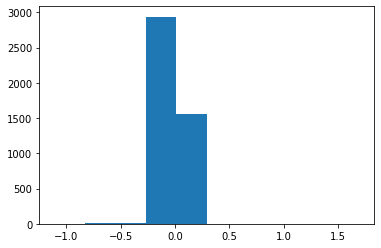

In [51]:
plt.hist(errors)

In [56]:
import torcheval as te 
tss,params = next(iter(DataLoader(dataset, batch_size=len(dataset))))
r2 = te.metrics.functional.r2_score(net(tss),params[:,1:])
r2

tensor(0.8835, device='cuda:0')